## Analyzing GPT2 embeddings

In [ ]:
# from transformers import GPT2LMHeadModel
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load gpt2 fast-tokenizer and gpt2 large (770M) model (model can take > 30min ot load in local, 10s in kaggle)
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2-large", use_fast=True)
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2-large")

# Get embedding matrix and save it locally to speeed up future uses
word_embeddings = model.transformer.wte.weight      # 50K: vocab size  x  1280: d_model
torch.save(word_embeddings, 'word_embeddings.pt')   # fp32  ;  ~256MB = 4 x (50Kx1280)

In [9]:
# Load embedding matrix on gpu
word_embeddings = torch.load('word_embeddings.pt', map_location=torch.device('cuda'), weights_only=True)
print(f"shape of the embedding matrix: {word_embeddings.shape}\n")
print(f"Chunk of the embedding of the word 'hello':\n {word_embeddings[tokenizer('hello')['input_ids'][0]][:10]}")

shape of the embedding matrix: torch.Size([50257, 1280])

Chunk of the embedding of the word 'hello':
 tensor([-0.2132,  0.0170, -0.0069,  0.1358, -0.0563,  0.0098, -0.0777,  0.0074,
        -0.0020,  0.0942], device='cuda:0', grad_fn=<SliceBackward0>)


#### Useful function

In [10]:
def is_in_vocab(token, tokenizer, verbose=True):
    existence = tokenizer.get_vocab().get(token) is not None
    if verbose:
        print(f"'{token}' exists in the vocabulary !\n") if existence else print(f"'{token}' does NOT exist in the vocabulary...\n")
    return existence

#### Example: the token `vector`

In [54]:
# Encoding for token 'vector'
if is_in_vocab("vector", tokenizer):
    vector_token = tokenizer('vector')['input_ids'][0]
    vector_embedding = word_embeddings[vector_token]

    # Most cosine-similar tokens to 'vector' in the vocabulary
    similarity1 = torch.cosine_similarity(word_embeddings, vector_embedding.unsqueeze(0), dim=1)
    top_similarities, top_indices = torch.topk(similarity1, 20)
    top_words = tokenizer.convert_ids_to_tokens(top_indices)
    top_words = '; '.join(top_words)
    print(f"Top 20 most similar words to 'vector' using cosine similarity: \n{top_words}")

    # Most EucDistance-similar tokens to 'vector' in the vocabulary
    similarity2 = torch.cdist(word_embeddings, vector_embedding.unsqueeze(0))
    top_similarities, top_indices = torch.topk(-similarity2[:,0], 20) # similarity = - distance
    top_words = tokenizer.convert_ids_to_tokens(top_indices)
    top_words = '; '.join(top_words)
    print(f"\nTop 20 most similar words to 'vector' using euclidian distance: \n{top_words}")

'vector' exists in the vocabulary !

Top 20 most similar words to 'vector' using cosine similarity: 
vector; Ġvector; Vector; Ġvectors; ĠVector; vec; string; array; Ġvec; template; sequence; sector; pointer; dimensional; iterator; Orderable; isSpecial; factor; map; aditional

Top 20 most similar words to 'vector' using euclidian distance: 
vector; Ġvector; Vector; Ġvectors; ĠVector; the; what; What; string; It; which; from; for; this; that; Although; For; Ġvec; We; This


In [59]:
# Most CustomDistance-similar tokens to 'vector' in the vocabulary
similarity3 = similarity1 - similarity2[:,0] * (similarity1.norm()/similarity2[:,0].norm())   # combines both distances
top_similarities, top_indices = torch.topk(similarity3, 20) # similarity = - distance
top_words = tokenizer.convert_ids_to_tokens(top_indices)
top_words = '; '.join(top_words)
print(f"\nTop 20 most similar words to 'vector' using combined distance: \n{top_words}")


Top 20 most similar words to 'vector' using combined distance: 
vector; Ġvector; Vector; Ġvectors; ĠVector; vec; string; Ġvec; array; template; sequence; sector; dimensional; pointer; map; integer; iterator; factor; target; density


#### Quick check

In [13]:
eng_math_list = ['square', 'triangle', 'ball', 'cercle', 'function', 'converge', 'diverge', 'positive', 'matrix', 'sequence', 'integer', ]
fre_math_list = ['carré', 'triangle', 'boule', 'cercle', 'fonction', 'converge', 'diverge', 'positif', 'matrice', 'suite', 'entier', ]
for word in eng_math_list:
    is_in_vocab(word, tokenizer)
print()
for word in fre_math_list:
    is_in_vocab(word, tokenizer)

'square' exists in the vocabulary !

'triangle' does NOT exist in the vocabulary...

'ball' exists in the vocabulary !

'cercle' does NOT exist in the vocabulary...

'function' exists in the vocabulary !

'converge' does NOT exist in the vocabulary...

'diverge' does NOT exist in the vocabulary...

'positive' exists in the vocabulary !

'matrix' does NOT exist in the vocabulary...

'sequence' exists in the vocabulary !

'integer' exists in the vocabulary !


'carré' does NOT exist in the vocabulary...

'triangle' does NOT exist in the vocabulary...

'boule' does NOT exist in the vocabulary...

'cercle' does NOT exist in the vocabulary...

'fonction' does NOT exist in the vocabulary...

'converge' does NOT exist in the vocabulary...

'diverge' does NOT exist in the vocabulary...

'positif' does NOT exist in the vocabulary...

'matrice' does NOT exist in the vocabulary...

'suite' does NOT exist in the vocabulary...

'entier' does NOT exist in the vocabulary...



* GPT2 wasn't a multilangual model. Its vocabulary meaningful tokens mainly consist of **english** words.
* Given the tokenization algorithm (BPE), many words can be split or packed and this won't exist in vocabulary

* **Let's choose a small set of english vocabulary among the vocabulary suggested in the paper data, make sure they're all represented by single token and analyze their pairwise similarity**

#### Choosing vocabulary

In [14]:
vocab_excel_path = r'..\Vocabulary\vocabularyFrenchEnglish.xlsx'
df = pd.read_excel(vocab_excel_path, sheet_name='EnglishVocabulary')
eng_vocab = df['word'].tolist()
df.head()

,word,Log Math freq,Log Nonmath Freq,Raw Math freq,Raw Nonmath freq,Present in French Vocabulary,Unnamed: 6,1000
0,number,3.534506,1.344005,0.003424,0.000022,no,NaN,NaN
1,function,3.508372,1.317871,0.003224,0.000021,no,NaN,NaN
2,one,3.473865,1.283365,0.002978,0.000019,no,NaN,NaN
3,set,3.459629,1.269128,0.002882,0.000019,no,NaN,NaN
4,group,3.407209,1.216707,0.002554,0.000016,no,NaN,NaN


In [15]:
is_in_vocab_list = list(map(lambda word: is_in_vocab(word, tokenizer, verbose=False), eng_vocab))
print(f"{is_in_vocab_list.count(True)} words out of {len(eng_vocab)} exist in the tokenizer vocabulary")

264 words out of 1000 exist in the tokenizer vocabulary


In [16]:
df['is_in_vocab'] = is_in_vocab_list
df.head(10)

,word,Log Math freq,Log Nonmath Freq,Raw Math freq,Raw Nonmath freq,Present in French Vocabulary,Unnamed: 6,1000,is_in_vocab
0,number,3.534506,1.344005,0.003424,0.000022,no,NaN,NaN,True
1,function,3.508372,1.317871,0.003224,0.000021,no,NaN,NaN,True
2,one,3.473865,1.283365,0.002978,0.000019,no,NaN,NaN,True
3,set,3.459629,1.269128,0.002882,0.000019,no,NaN,NaN,True
4,group,3.407209,1.216707,0.002554,0.000016,no,NaN,NaN,True
5,space,3.406496,1.215994,0.002550,0.000016,no,NaN,NaN,True
6,two,3.357436,1.166936,0.002277,0.000015,no,NaN,NaN,True
7,theory,3.355734,1.165232,0.002268,0.000015,no,NaN,NaN,False
8,point,3.335718,1.145215,0.002166,0.000014,no,NaN,NaN,True
9,theorem,3.232078,1.041578,0.001706,0.000011,no,NaN,NaN,False


In [17]:
valid_vocab_info = df[df['is_in_vocab']]              # Subset of the 264 valid words (valid := is a gpt2 token)
valid_vocab_info.head(10)

,word,Log Math freq,Log Nonmath Freq,Raw Math freq,Raw Nonmath freq,Present in French Vocabulary,Unnamed: 6,1000,is_in_vocab
0,number,3.534506,1.344005,0.003424,0.000022,no,NaN,NaN,True
1,function,3.508372,1.317871,0.003224,0.000021,no,NaN,NaN,True
2,one,3.473865,1.283365,0.002978,0.000019,no,NaN,NaN,True
3,set,3.459629,1.269128,0.002882,0.000019,no,NaN,NaN,True
4,group,3.407209,1.216707,0.002554,0.000016,no,NaN,NaN,True
5,space,3.406496,1.215994,0.002550,0.000016,no,NaN,NaN,True
6,two,3.357436,1.166936,0.002277,0.000015,no,NaN,NaN,True
8,point,3.335718,1.145215,0.002166,0.000014,no,NaN,NaN,True
10,example,3.226857,1.036357,0.001686,0.000011,no,NaN,NaN,True
11,form,3.212075,1.021574,0.001630,0.000011,no,NaN,NaN,True


#### Start by studying numbers

In [51]:
valid_vocab = valid_vocab_info['word'].tolist()[:50]   # List of most math-frequent 50 valid words
print(valid_vocab)

['number', 'function', 'one', 'set', 'group', 'space', 'two', 'point', 'example', 'form', 'define', 'graph', 'value', 'problem', 'order', 'first', 'vector', 'field', 'element', 'system', 'method', 'result', 'term', 'line', 'model', 'real', 'property', 'complex', 'linear', 'definition', 'product', 'state', 'sequence', 'variable', 'square', 'map', 'class', 'integer', 'mean', 'proof', 'three', 'dimensional', 'zero', 'ring', 'edge', 'sum', 'plane', 'analysis', 'dimension', 'type']


In [19]:
are_numbers_in_vocab = list( map(lambda word: is_in_vocab(word, tokenizer, verbose=False), [str(i) for i in range(100)]) )
print(f"{are_numbers_in_vocab.count(True)} numbers out of 100 exist in the tokenizer vocabulary")

100 numbers out of 100 exist in the tokenizer vocabulary


* All numbers between 0 and 99 are valid tokens
* If one wants to study their cross-similarities, it would make ~5K `(100 x 101 / 2)` similarities to compute (on 1.2K dimensional vectors). 
* Well, it's feasible.

In [20]:
# continue on cpu (no real need for gpu)
cpu_embeddings = torch.load('word_embeddings.pt', map_location=torch.device('cpu'), weights_only=True)
cpu_embeddings = cpu_embeddings.detach()

[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 940, 1157, 1065, 1485, 1415, 1314, 1433, 1558, 1507, 1129, 1238, 2481, 1828, 1954, 1731, 1495, 2075, 1983, 2078, 1959, 1270, 3132, 2624, 2091, 2682, 2327, 2623, 2718, 2548, 2670, 1821, 3901, 3682, 3559, 2598, 2231, 3510, 2857, 2780, 2920, 1120, 4349, 4309, 4310, 4051, 2816, 3980, 3553, 3365, 3270, 1899, 5333, 5237, 5066, 2414, 2996, 2791, 3134, 3104, 3388, 2154, 4869, 4761, 4790, 4524, 2425, 4304, 3324, 3695, 3720, 1795, 6659, 6469, 5999, 5705, 5332, 4521, 5774, 3459, 4531, 3829, 6420, 5892, 6052, 5824, 3865, 4846, 5607, 4089, 2079]


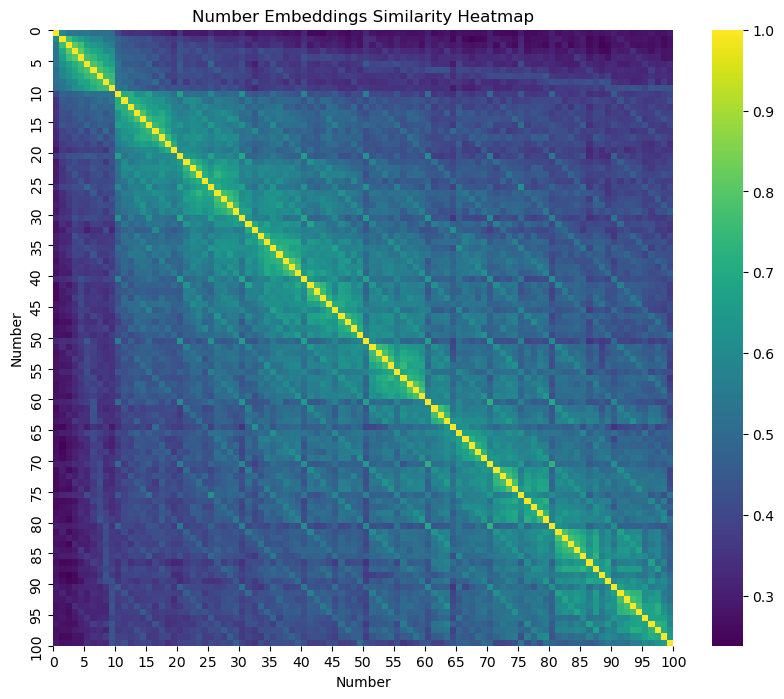

In [49]:
max_nb = 100
tokens_ids = [tokenizer(str(i))['input_ids'][0] for i in range(max_nb)]
print(tokens_ids)

numbers_embeddings = torch.stack([cpu_embeddings[tokens_ids[i]] for i in range(max_nb)])

def cross_similarity_matrix(stacked_embeddings):
    Nb_tokens = stacked_embeddings.size(0)
    similarities = torch.zeros(Nb_tokens, Nb_tokens)
    for i in range(Nb_tokens):
        similarities[i, i:] = torch.cosine_similarity(stacked_embeddings[i, :], stacked_embeddings[i:, :], dim=1)
    similarities = similarities + similarities.T - torch.eye(Nb_tokens)  # Fill the un-computed half (redundant) of the matrix.
    return similarities


nb_similarities = cross_similarity_matrix(numbers_embeddings)
nb_similarities_df = pd.DataFrame(nb_similarities.numpy(), columns=range(max_nb), index=range(max_nb))

# Plot heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(nb_similarities_df, cmap='viridis', annot=False)
plt.title('Number Embeddings Similarity Heatmap')
plt.xlabel('Number'); plt.ylabel('Number')
plt.xticks([5*i for i in range(21)], [5*i for i in range(21)]); plt.yticks([5*i for i in range(21)], [5*i for i in range(21)])
plt.show()

In [47]:
# cross similarity between 37 and 77
print(nb_similarities_df.mean().mean())
torch.cosine_similarity(numbers_embeddings[37], numbers_embeddings[77], dim=0)

0.48406222


tensor(0.5795)

* A first pattern appears: close numbers are generally more similar.
* Another more interesting and explainable pattern is that `multiplicatively linked` numbers' embeddings (such as 75 and 25) tend to be significantly more similar than other unlinked pairs (s.a 75 and 41).
* Same for pairs with difference = 10 or even 5 (less visible) ===> Cf. sub-diagonals
* **Numbers between 0 and 10** have higher scores and are much less similar to numbers greater than 10.

* More generally, more similarity is there for numbers who have good chance to co-exist together in a same math equation/sample.
* These observations make sense especially for numbers that are used more often. We know that a math dataset will most probably contain more 25s than 37s.

* **Critique**: A challenging factor here is that embeddings got formed after training on mostly webdata. So it would't be surprising to have some un-confirmed expectations or even `conter-intuitive` observations at a first sight. Simply because the representation of 31 for example does not necessarily mostly hold its arithmetic semantic/meaning but might be significantly affected by its usage as the age of a person (especially celebrities) or temperatures, etc. <br>
Here we understand even better the importance of **the consideration of 3 different types embeddings: math, non-math, gloabl**. Done in the paper. <br>
**Example**: 37 and 77 have an above average score although, purely mathematically speaking they don't have this natural relation. This could be explained by the relation: `37°C = 77°F`!

#### Next: math token pairs
* As initated above I've chosen to study pairwise similarities between 50 most frequent math tokens extracted from the paper vocabulary dataset

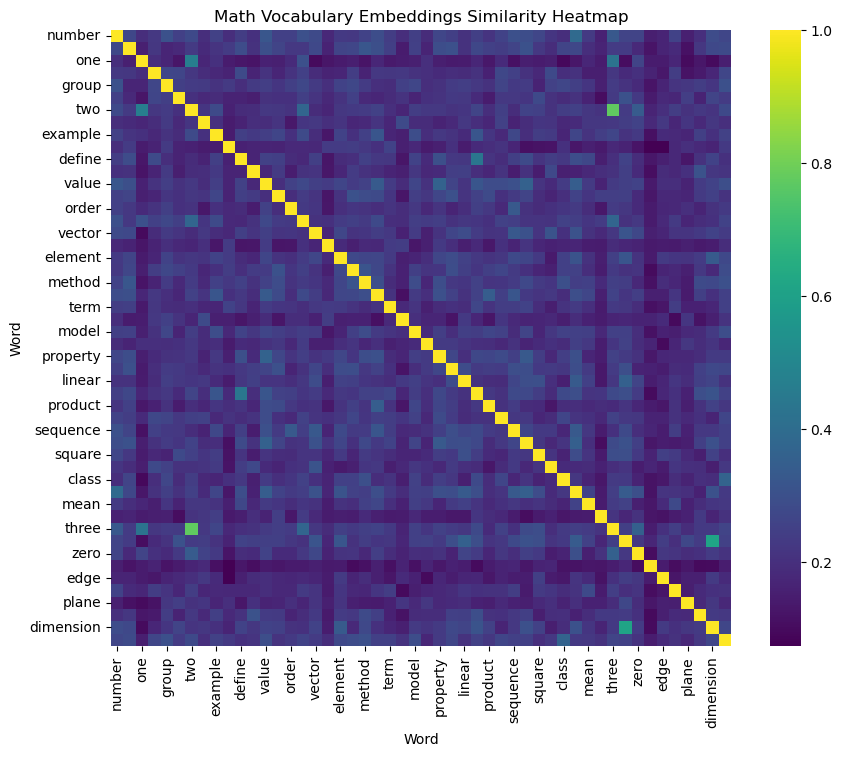

In [52]:
# stacked embeddings of valid_vocab
valid_tokens_ids = [tokenizer(word)['input_ids'][0] for word in valid_vocab]
valid_vocab_embeddings = torch.stack([cpu_embeddings[valid_tokens_ids[i]] for i in range(len(valid_vocab))])
# cross similarity betweeen them all
valid_similarities = cross_similarity_matrix(valid_vocab_embeddings)
valid_similarities_df = pd.DataFrame(valid_similarities.numpy(), columns=valid_vocab, index=valid_vocab)
# heatmap
plt.figure(figsize=(10, 8)) 
sns.heatmap(valid_similarities_df, cmap='viridis', annot=False)
plt.title('Math Vocabulary Embeddings Similarity Heatmap')
plt.xlabel('Word'); plt.ylabel('Word')
plt.show()

Again many things are explainable (fortunately):
 - `function` is quite close to `method`.
 - `define` and `definition` are close for their grammatical and sematic relation (non-math).
 - `two` and `one` and `three` relatively high similarity score showcases that even gpt2 (an out-dated and relatively small model) captures some of the mathematical semantic space in its embeddings.
 - `three` and `dimension`: talk about the same thing (3D space).
 - `property` and `value` are quite similarly represented. But one cannot confirm this as a mathematical sematic relation. It can simply be from the fact that when talking about a property (ex. house) we discuss its value.

### To be continued.
 - Perform a PCA and re-analyze.
 - Cluster.
 - Try with Llama 3.1 3B embedding (richer voab, trained more than gp2 on math, multilangual so useful for french too).